In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# class NeuralNetwork
# a multi-class classifier
# optimization algorithm: gradient descent
# activation function: Sigmoid
# cost or loss function: binary cross entropy
class NeuralNetwork:
    # constructor
    def __init__(self):
      # data
      self.data = None
      self.X = None
      self.y = None

      # input layer, hidden layer(s), and output layer
      self.layers = []

      # coefficients (or weights)
      self.thetas = []

      # user-defined hyperparameters
      # (learning parameters)

      # learning rate
      self.alpha = 0.1

      # random seed
      # seed=27,32,33,35,38,39
      self.seed = 27

      # number of iterations in training
      self.num_iter = 10000

      # regularization rate
      self.rlambda = 0

      # mesh grid size
      self.grid_size = 1000

    # set learning rate
    def set_learning_rate(self, alpha):
      self.alpha = alpha

    # set random seed
    def set_random_seed(self, seed):
      self.seed = seed

    # set number of iterations in training
    def set_num_iterations(self, num_iter):
      self.num_iter = num_iter

    # set regularization rate
    def set_reg_rate(self, rlambda):
      self.rlambda = rlambda

    # set grid size
    def set_grid_size(self, grid_size):
      self.grid_size = grid_size

    # add a layer to the end
    def add_layer(self, num_neurons):
      self.layers.append(num_neurons)

    @staticmethod
    def one_encode(i, size):
      encoded = np.zeros((1, size))
      encoded[0, i % size] = 1.0
      return encoded

    @staticmethod
    def sigmoid(z):
      return (1.0/(1+np.exp(0-z)))

    # delta for output layer
    @staticmethod
    def delta_output_layer(ai, yi):
      # single data point
      # delta_layer = ai_layer - yi
      delta = ai - yi
      return delta

    # delta for hidden layer
    @staticmethod
    def delta_hidden_layer(theta, delta_next, ai):
      # single data point
      # delta = thetalayer.T * delta_layer+1 .* ai_layer .* (1 - ai_layer)
      delta = np.multiply(np.dot(np.transpose(theta), delta_next), np.multiply(ai, (1 - ai)))
      # drop delta0
      delta = delta[1:]
      return delta

    # gradient descent
    @staticmethod
    def gradient_descent(delta_next, ai):
      # single data point
      # grad_layer = delta_layer+1 * ai_layer.T
      grad = np.dot(delta_next, np.transpose(ai))
      return grad

    # forward propagation
    def forward_propagation(self, xi):
      # single data point
      al = [xi]
      ai = xi
      for i in range(len(self.thetas)):
        theta = self.thetas[i]

        # zi = theta * (ai)
        # ai = exp(-zi)
        zi = np.dot(theta, ai)
        ai1 = self.sigmoid(zi)

        # do not add bias unit to last ai
        if i != len(self.thetas)-1:
          o = np.ones((1, 1))
          ai1 = np.append(o, ai1, axis=0)

        al.append(ai1)
        ai = ai1
      return al

    # back propagation
    # compute cost and gradients for a single data point
    def back_propagation(self, xi, yi):
      # init gradient matrices
      grad = []
      for i in range(len(self.thetas)):
        grad.append(np.zeros(self.thetas[i].shape))

      # forward propagation
      al = self.forward_propagation(xi)
      #print("al", al)

      # cost function
      i = len(al)-1
      #print("i", i)
      ai = al[i]
      J = np.sum(np.multiply(yi, (0-np.log(ai))) +
                 np.multiply((1 - yi), (0-np.log(1 - ai))))

      # back propagation
      # gradient descent
      # output layer
      delta = self.delta_output_layer(ai, yi)
      grad[i-1] = self.gradient_descent(delta, al[i-1])

      # hidden layer
      prev = delta
      for i in range(len(al)-2, 0, -1):
        #print("i", i)
        ai = al[i]
        delta = self.delta_hidden_layer(self.thetas[i], prev, ai)
        grad[i-1] = self.gradient_descent(delta, al[i-1])
        prev = delta

      return [J, grad]

    # compute cost and gradient
    # (with regularization for training)
    def cost_and_gradient(self):
      # cost function
      # add y * (-log (h)) + (1 - y) * (-log(1 - h))
      # for all output layers for every data points
      J = 0.0
      # init theta gradient matrices
      theta_grad = []
      for i in range(len(self.thetas)):
        theta_grad.append(np.zeros(self.thetas[i].shape))

      # loop through each data point and accumulate gradient
      # for each layer
      m = self.X.shape[0]
      for i in range(0, m):
        #print(i)
        xi = np.matrix(self.X[i])
        xi = np.transpose(xi)
        yi = np.matrix(self.y[i])
        yi = np.transpose(yi)
        #print("xi", xi)
        #print("yi", yi)

        # compute cost and gradients for a single data point
        [cost, grad] = self.back_propagation(xi, yi)
        #print(cost)
        #print(grad)
        J += cost
        for i in range(len(theta_grad)):
          theta_grad[i] = theta_grad[i] + grad[i]

      # regularization (cost function)
      # add theta[i,j]**2 for all layers (j>0) to the cost
      R = 0.0
      if self.rlambda > 0:
        for i in range(len(self.thetas)):
          theta = np.copy(self.thetas[i])
          theta[:,0] = 0
          R += np.sum(np.multiply(theta, theta))
      J = J * 1.0/m + self.rlambda/(2*m) * R

      for i in range(len(theta_grad)):
        # regularization (gradient descent)
        # add lambda * theta[i, j] (j>0) to theta_grad[l]
        if self.rlambda > 0:
          theta = np.copy(self.thetas[i])
          theta[:,0] = 0
          theta_grad[i] = theta_grad[i] + self.rlambda * theta
        theta_grad[i] = 1.0/m * theta_grad[i]

      return [J, theta_grad]

    # compute averaged cost for all data points
    # (with or without regularization)
    def cost_function(self, X, y, reg=False):
      # add y * (-log (h)) + (1 - y) * (-log(1 - h))
      # for all output layers for every data points
      J = 0.0
      m = X.shape[0]

      # loop through each data point and accumulate cost
      for i in range(0, m):
        #print(i)
        xi = np.matrix(X[i])
        xi = np.transpose(xi)
        yi = np.matrix(y[i])
        yi = np.transpose(yi)
        #print("xi", xi)
        #print("yi", yi)

        # forward propagation
        al = self.forward_propagation(xi)
        ai = al[len(al)-1]
        J += np.sum(np.multiply(yi, (0-np.log(ai))) +
                    np.multiply((1 - yi), (0-np.log(1 - ai))))

      # regularization (cost function)
      # add theta[i,j]**2 for all layers (j>0) to the cost
      R = 0.0
      if reg and self.rlambda > 0:
        for i in range(len(self.thetas)):
          theta = np.copy(self.thetas[i])
          theta[:,0] = 0
          R += np.sum(np.multiply(theta, theta))

      J = 1.0/m * J + self.rlambda/(2*m) * R
      return J

    # init thetas (coefficients)
    def init_thetas(self):
      np.random.seed(self.seed)
      for i in range(len(self.layers)-1):
        self.thetas.append(np.random.randn(self.layers[i+1], self.layers[i]+1))

      #for i in range(len(self.thetas)):
      #  print("theta", i + 1)
      #  print(self.thetas[i])

    # init data for input layer
    def init_input_data(self):
      data = np.copy(self.data)

      # randomly shuffle the training data first
      np.random.shuffle(data)
      #print("random", data)

      n = data.shape[1]
      #print(n)

      # X, y
      # row matrix
      #x = data[:, [0, n-2]]
      x = data[:, 0: n-1]
      y = data[:, [n-1]]
      #print(x)
      #print(y)
      #print(x.shape)
      #print(y.shape)

      # column matrix
      o = np.ones((x.shape[0], 1))
      #print(o)
      X = np.append(o, x, axis=1)

      self.X = X
      self.y = y
      # multi-class classification
      # convert y to one and zeros column
      num_output = self.layers[len(self.layers)-1]
      if num_output >= 3:
        tmp = self.one_encode(y[0,0], num_output)
        for i in range(1, y.shape[0]):
          tmp = np.concatenate((tmp,self.one_encode(y[i,0], num_output)), axis=0)
        self.y = tmp

      #print("X", self.X)
      #print("y", self.y)
      #print(self.y.shape)

    # train a neural network
    def fit(self, data):
      self.data = data
      print("data", data)

      # init thetas (coefficients)
      self.init_thetas()

      count = 0
      while count < self.num_iter:
        count += 1

        # randomly shuffle the training data and
        # init data for input layer
        self.init_input_data()

        # loop through all data points and compute
        # averaged cost and gradient descents
        [J, theta_grad] = self.cost_and_gradient()
        #print("cost", J)

        # update thetas (coefficients)
        for i in range(len(self.thetas)):
           self.thetas[i] = self.thetas[i] - self.alpha * theta_grad[i]

      print("Gradient Decent parameters:")
      for i in range(len(self.thetas)):
        print(self.thetas[i])

      # compute cost
      #print(self.X)
      #print(self.y)
      J = self.cost_function(self.X, self.y)
      print("cost", J)

    # predict a data
    def predict(self, x_pred):
      for x in x_pred:
        print("prediction", x)
        xi = np.matrix(x)
        xi = np.transpose(xi)
        o = np.ones((1, 1))
        xi = np.append(o, xi, axis=0)
        al = self.forward_propagation(xi)
        ai_pred = al[len(al)-1]
        #print(ai_pred)
        if len(ai_pred) == 1:
          # binary classification
          if ai_pred[0,0] >= 0.5:
            print("label 1")
          else:
            print("label 0")
        else:
          # multi-class classification
          print("label", np.argmax(ai_pred, axis=0)[0,0])

    # hypothesis mesh for countur
    def hypothesis_mesh(self, X1, X2):
      #print("X1.shape={}".format(X1.shape))
      #print("X2.shape={}".format(X2.shape))

      # hidden layer 1
      (dim_x, dim_y) = X1.shape
      n = self.thetas[0].shape[0]
      Z = np.zeros((n, dim_x, dim_y))
      a = np.zeros((n+1, dim_x, dim_y))
      #print("Z.shape={}".format(Z.shape))
      #print("a.shape={}".format(a.shape))

      for i in range(n):
        Z[i] = self.thetas[0].item((i, 0)) + self.thetas[0].item((i, 1)) * X1 + self.thetas[0].item((i, 2)) * X2
      a[0,:,:] = 1
      a[1:,:,:] = self.sigmoid(Z)
      a2 = a

      # hidden layer 2+
      for l in range(1, len(self.thetas)-1):
        n = self.thetas[l].shape[0]
        Z = np.zeros((n, dim_x, dim_y))
        a = np.zeros((n+1, dim_x, dim_y))
        #print("Z.shape={}".format(Z.shape))
        #print("a.shape={}".format(a.shape))
        for i in range(n):
          n2 = self.thetas[l].shape[1]
          for j in range(n2):
            Z[i] += self.thetas[l].item((i, j))*a2[j,:,:]
        a[0,:,:] = 1
        a[1:,:,:] = self.sigmoid(Z)
        a2 = a

      # output layer
      l = len(self.thetas) - 1
      n = self.thetas[l].shape[0]
      Z = np.zeros((n, dim_x,dim_y))
      a = np.zeros((n, dim_x, dim_y))
      #print("Z.shape={}".format(Z.shape))
      #print("a.shape={}".format(a.shape))
      for i in range(n):
        n2 = self.thetas[l].shape[1]
        for j in range(n2):
          Z[i] += self.thetas[l].item((i, j))*a2[j,:,:]
      a = self.sigmoid(Z)
      return a

    # display contour
    def display_contour(self, grid_size =1000):
      self.grid_size = grid_size

      colors=['blue', 'red', 'green', 'orange','purple',
              'brown', 'pink', 'gray', 'olive', 'cyan']
      fig,ax=plt.subplots(1,1)

      # plot data
      # num of neurons in the output layer
      num_output = self.layers[len(self.layers)-1]
      if num_output >= 3:
        # multi-class classification
        for i in range(num_output):
          x0 = np.array(self.data[:, 0][self.data[:, 2] == i])
          y0 = np.array(self.data[:, 1][self.data[:, 2] == i])
          ax.scatter(x0, y0, color=colors[i])
      else:
        # binary classification
        x0 = np.array(self.data[:, 0][self.data[:, 2] == 0])
        y0 = np.array(self.data[:, 1][self.data[:, 2] == 0])
        x1 = np.array(self.data[:, 0][self.data[:, 2] == 1])
        y1 = np.array(self.data[:, 1][self.data[:, 2] == 1])
        ax.scatter(x0, y0, color=colors[0])
        ax.scatter(x1, y1, color=colors[1])

      # plot contour
      x_min = np.min(self.data[:, 0]) - 4
      x_max = np.max(self.data[:, 0]) + 4
      y_min = np.min(self.data[:, 1]) - 4
      y_max = np.max(self.data[:, 1]) + 4

      # create mesh grid matrices
      xlist = np.linspace(x_min, x_max, self.grid_size)
      ylist = np.linspace(y_min, y_max, self.grid_size)
      X, Y = np.meshgrid(xlist, ylist)

      # plot contour
      Z = self.hypothesis_mesh(X, Y);
      #print(Z)

      labels = [0.5]
      for i in range(len(Z)):
        cp = ax.contour(X, Y, Z[i], labels)
        ax.clabel(cp, inline=True, fontsize=10, colors=colors[i])


data [[-2 -7  0]
 [ 3 -3  0]
 [10  8  0]
 [16  5  0]
 [ 2  2  1]
 [-1  8  1]
 [ 8 10  1]
 [14 18  1]]
Gradient Decent parameters:
[[ 2.47715711 -1.78588785  1.5241794 ]
 [-1.66622369  1.66705003 -1.51931724]
 [-0.05859954  0.42720143  1.34487343]
 [ 1.20594496  0.45532095 -0.02247165]
 [ 1.22351519 -1.79197197  1.74176257]]
[[-1.46138755  4.93312986 -5.24726588  0.91610432 -0.50879779  4.09034726]]
cost 0.0016759737847336085
prediction [10  2]
label 0
prediction [ 5 10]
label 1


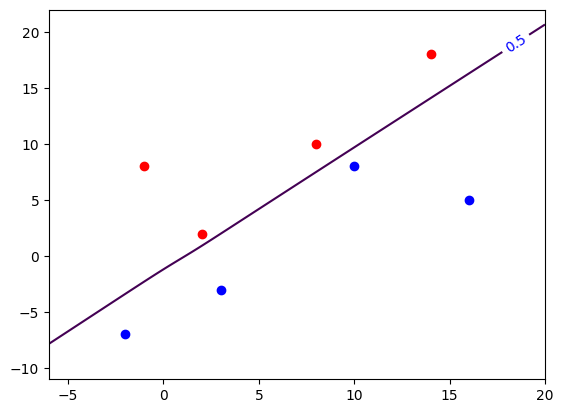

In [ ]:
# example 1
# x0, x1, x2
# 2x5x1
data = np.array([[-2,-7,0], [3,-3,0], [10,8,0], [16,5,0], [2,2,1], [-1,8,1], [8,10,1], [14,18,1]])
nn = NeuralNetwork()
nn.add_layer(2)
nn.add_layer(5)
nn.add_layer(1)
nn.fit(data)
x_pred = np.array([[10, 2], [5, 10]])
nn.predict(x_pred)
nn.display_contour()

data [[-2 -7  1]
 [ 3 -3  0]
 [10  8  0]
 [16  5  1]
 [ 2  2  0]
 [-1  8  1]
 [ 8 10  0]
 [14 18  1]]
Gradient Decent parameters:
[[ 1.41219765 -0.88475989  1.55620021]
 [ 0.22512789  2.10464581 -0.19381502]
 [-5.51211151  0.4673676   0.04639375]
 [-0.3184062  -1.01435065  0.89541852]
 [-0.35310747 -2.46755209  0.19878093]]
[[-0.03878884  2.07886744  1.83521988 -4.5112015  -1.72255658 -2.32610344]
 [ 0.49825737 -0.86233618 -1.18564085  2.20314151 -0.42622019  1.29365129]
 [-1.71916244 -0.96603165 -0.91514102  3.22711103  2.8210949   3.65682245]
 [-0.19544877  0.36425589  0.58180519 -1.52904092  1.10728985  0.2883522 ]
 [ 0.29002756 -0.86728172 -1.99294741  3.31877695  0.84130047  0.96279009]]
[[-0.92628301 -7.33710522  2.60113929  5.42242018 -1.32877863  3.89771049]]
cost 0.0021118848212899576
prediction [10  2]
label 0
prediction [15  0]
label 1


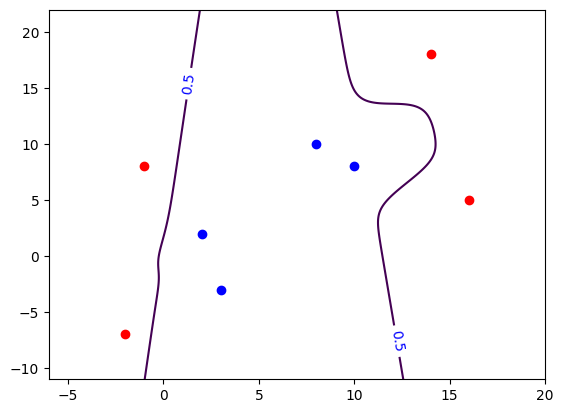

In [ ]:
# example 2
# x0, x1, x2
# 2x5x5x1
data = np.array([[-2,-7,1], [3,-3,0], [10,8,0], [16,5,1], [2,2,0], [-1,8,1], [8,10,0], [14,18,1]])
nn = NeuralNetwork()
nn.add_layer(2)
nn.add_layer(5)
nn.add_layer(5)
nn.add_layer(1)
nn.fit(data)
x_pred = np.array([[10, 2], [15, 0]])
nn.predict(x_pred)
nn.display_contour()

data [[ -2  -7   1]
 [  3  -3   0]
 [ 10   8   0]
 [ 16   5   1]
 [  2   2   0]
 [ -1   8   1]
 [  8  10   0]
 [  9  -7   1]
 [ 14  18   1]
 [  5  12   1]
 [  2 -10   1]]
Gradient Decent parameters:
[[ 1.38976726 -2.09025109 -0.42996216]
 [ 0.87326353  1.98498596  0.84340656]
 [ 1.50858976 -0.29082846  0.48175486]
 [-6.12415798  0.70678983 -0.2068116 ]
 [-1.83514339 -2.43165235  2.02594811]]
[[-5.23544386e-01 -1.12069480e+00  1.54208138e+00  1.61478179e+00
  -2.55394906e+00 -3.64878684e+00]
 [ 1.63890611e-01  4.29565886e-01 -1.26030434e+00 -2.29344079e-01
  -1.23367959e+00  1.10448353e+00]
 [-7.04960249e-01  2.42963850e+00 -1.44211017e+00 -1.75565283e+00
   4.99123005e+00  5.50152892e+00]
 [-2.41137668e-01  5.36994681e-01 -4.47369806e-01 -1.55388370e+00
   2.37870475e+00  1.78543243e+00]
 [ 1.03395102e-03  1.26898478e+00 -2.07011118e+00  3.43195190e-01
   2.41703064e-01  9.51071081e-01]]
[[-1.7699527  -6.43252014  0.89434383  8.05760242  2.7550489   1.70600718]]
cost 0.0030414808844167

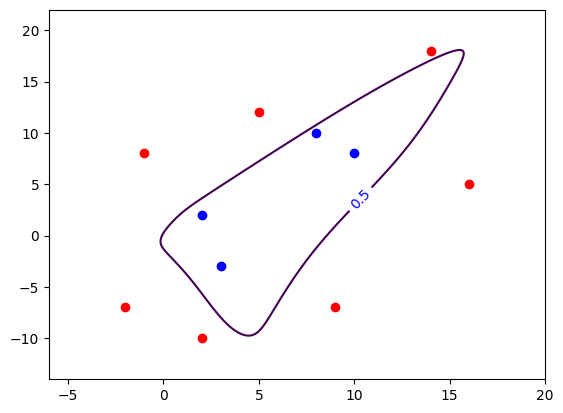

In [ ]:
# example 3
# x0, x1, x2
# 2x5x5x1
data = np.array([[-2,-7,1], [3,-3,0], [10,8,0], [16,5,1], [2,2,0], [-1,8,1], [8,10,0], [9,-7,1], [14,18,1], [5,12,1], [2,-10,1]])
nn = NeuralNetwork()
nn.add_layer(2)
nn.add_layer(5)
nn.add_layer(5)
nn.add_layer(1)
#nn.set_reg_rate(0.001)
nn.fit(data)
x_pred = np.array([[10, 2], [5, 0]])
nn.predict(x_pred)
nn.display_contour()

data [[ -2  -7   1]
 [  3  -3   0]
 [ 10   8   0]
 [ 16   5   1]
 [  2   2   0]
 [ -1   8   1]
 [  8  10   0]
 [  9  -7   1]
 [ 14  18   1]
 [  5  12   1]
 [  2 -10   1]
 [ 13  10   1]
 [  6   1   1]
 [  5 -10   1]]
Gradient Decent parameters:
[[ 5.21357619  1.89824276 -1.89091804]
 [ 0.0345715   0.43069444  2.65663093]
 [-1.60202434 -2.95228763 -0.18451999]
 [ 1.14535946 -1.42131051  2.67687111]
 [-6.69326766  1.07016857 -0.61439038]]
[[ 1.63450707 -3.47124423  2.03942222  3.29976939 -1.86739383  2.45687258]
 [-0.05411898 -1.829987   -0.17398064  0.77942122  1.49840587  2.30194772]
 [ 0.18104902  0.33391309  0.42015028 -0.48051793 -3.07579285  0.9963936 ]
 [ 0.90019873 -0.8808503   0.14645077  0.30748685 -1.68930044  2.17731757]
 [-1.26780914  3.88026157 -2.1271648  -3.46193605  2.15910041 -5.27258641]]
[[-0.31166395  6.406863    1.34474313  1.02840646  2.82663804 -8.88644388]]
cost 0.007401912655900678
prediction [10  2]
label 1
prediction [5 3]
label 0


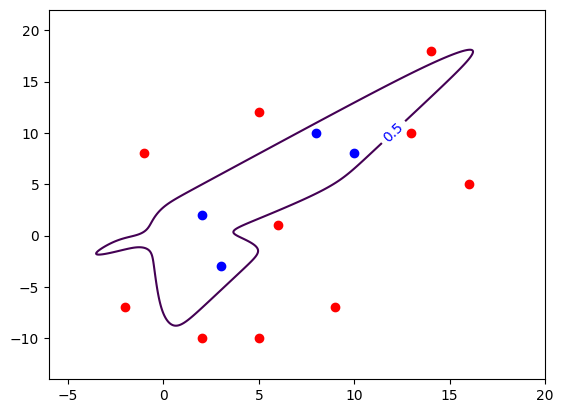

In [ ]:
# example 4
# x0, x1, x2
# 2x5x5x1
data = np.array([[-2,-7,1],[3,-3,0],[10,8,0],[16,5,1],[2,2,0],[-1,8,1],[8,10,0], [9,-7,1],[14,18,1], [5,12,1],[2,-10,1],[13,10,1],[6,1,1],[5,-10,1]])
nn = NeuralNetwork()
nn.add_layer(2)
nn.add_layer(5)
nn.add_layer(5)
nn.add_layer(1)
nn.set_random_seed(39)
nn.fit(data)
x_pred = np.array([[10, 2], [5, 3]])
nn.predict(x_pred)
nn.display_contour()

data [[ -2  -7   2]
 [  3  -3   0]
 [ 10   8   0]
 [ 16   5   1]
 [  2   2   0]
 [ -1   8   1]
 [  8  10   0]
 [  9  -7   2]
 [ 14  18   1]
 [  5  12   1]
 [  2 -10   2]
 [ 13  10   1]
 [  6   1   1]
 [  5 -10   2]]
Gradient Decent parameters:
[[ 5.28858118 -3.79169711  4.22221415]
 [ 0.09647783 -0.02224262  0.28333012]
 [-5.47283841 -1.55884587  1.64583318]
 [ 5.34421078  0.07110847  1.18752284]
 [ 0.03856362 -1.195723    2.57587832]
 [-1.21959429 -2.13670908  1.15901712]
 [-1.38886427 -0.14677894 -0.62708344]
 [ 1.99737208 -0.69567262 -1.50348797]]
[[ 0.60597634 -2.53032998  0.71699084 -2.54673912  0.87409674 -1.28263344
  -0.2118539   1.66142455  2.35583383]
 [-0.17560318  0.01203638  1.30825761 -0.17481331  2.81417418  0.42915025
   0.1817076   0.06154485 -1.82571915]
 [ 0.50870371 -0.04309736 -1.38503141  0.71286204 -5.07924312  0.6414411
   2.09406981  2.04491073  0.58186886]
 [ 2.22960292 -3.96630651  1.74471079  4.4505083  -1.74715954 -0.44077524
   3.27575552  0.45962142 -2.56

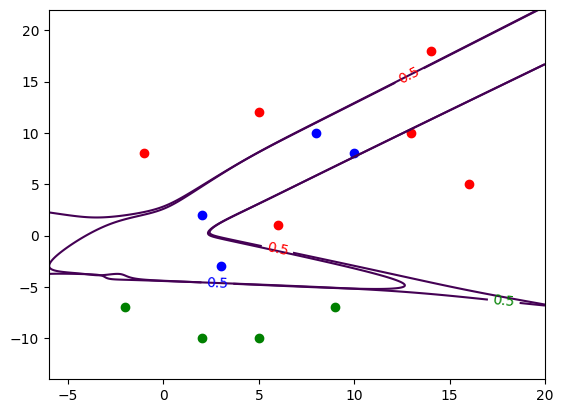

In [ ]:
# example 5
# x0, x1, x2
# 2x8x8x3
# multi-class classification
data = np.array([[-2,-7,2],[3,-3,0],[10,8,0],[16,5,1],[2,2,0],[-1,8,1],[8,10,0],[9,-7,2],[14,18,1],[5,12,1],[2,-10,2],[13,10,1],[6,1,1],[5,-10,2]])
nn = NeuralNetwork()
nn.add_layer(2)
nn.add_layer(8)
nn.add_layer(8)
nn.add_layer(3)
nn.set_random_seed(27)
nn.fit(data)
x_pred = np.array([[10, 2], [0, -7]])
nn.predict(x_pred)
nn.display_contour()

data [[0 0 1]
 [1 0 0]
 [1 1 1]
 [0 1 0]]
Gradient Decent parameters:
[[-3.00123237 -5.9107014   5.62277653]
 [ 3.29135188 -6.48619704  6.63356461]]
[[ -4.46609586 -10.3333479    9.66810832]]
cost 0.012956647615357232
prediction [10  2]
label 0
prediction [ 1 12]
label 0


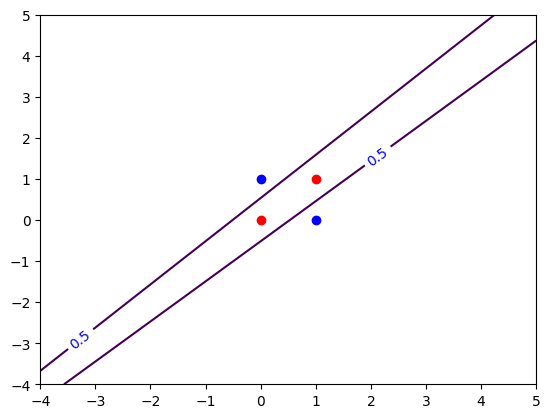

In [ ]:
# example 6
# x0, x1, x2
# 2x2x1
data = np.array([[0,0,1],[1,0,0],[1,1,1],[0,1,0]])
nn = NeuralNetwork()
nn.add_layer(2)
nn.add_layer(2)
nn.add_layer(1)
nn.set_random_seed(39)
nn.fit(data)
# predict (10, 2), (1, 12)
x_pred = np.array([[10, 2], [1, 12]])
nn.predict(x_pred)
nn.display_contour()

data [[-2 -7  1]
 [ 3 -3  0]
 [10  8  0]
 [16  5  1]
 [ 2  2  0]
 [-1  8  1]
 [ 8 10  0]
 [14 18  1]
 [ 7  0  0]
 [ 3  6  0]
 [ 6 12  1]
 [10 -2  1]
 [ 3 -6  1]
 [14 12  1]]
Gradient Decent parameters:
[[-1.72121208e+00 -1.99877976e+00  1.31919400e+00]
 [-4.23674124e-02 -2.28046861e+00  1.26091577e-01]
 [ 3.20257895e-01  2.04232511e-01  2.39682225e+00]
 [ 1.62827973e+00  1.78732832e+00  1.59960606e+00]
 [-3.98686482e+00 -8.43676217e-01  9.41379275e-01]
 [ 3.94075417e+00 -6.08283328e-02 -4.03777068e-01]
 [-1.02910680e+00 -2.87047115e+00 -2.18355764e+00]
 [-2.15608489e-03  6.31719644e-01 -1.34059590e+00]
 [ 2.53339433e-01 -1.74481434e+00 -2.02910494e-02]
 [-7.95513226e+00  9.29287170e-01 -2.69767238e-01]]
[[ 0.68945779  4.66925991  3.52965128 -2.33074266 -2.62515784  5.37313847
  -4.96836103  5.86798347  2.40289233  1.07259835 10.23076856]]
cost 0.012982591829902681
prediction [10  2]
label 1
prediction [ 1 12]
label 1


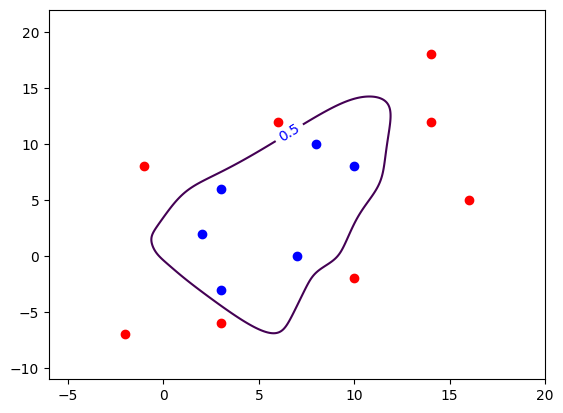

In [ ]:
# example 7
# x0, x1, x2
# 2x10x1
data = np.array([[-2,-7,1], [3,-3,0], [10,8,0], [16,5,1], [2,2,0], [-1,8,1], [8,10,0], [14,18,1], [7,0,0],[3,6,0],[6,12,1],[10,-2,1],[3,-6,1],[14,12,1]])
nn = NeuralNetwork()
nn.add_layer(2)
nn.add_layer(10)
nn.add_layer(1)
nn.fit(data)
x_pred = np.array([[10, 2], [1, 12]])
nn.predict(x_pred)
nn.display_contour()

data [[-2 -7  1]
 [ 3 -3  0]
 [10  8  0]
 [16  5  1]
 [ 2  2  0]
 [-1  8  1]
 [ 8 10  0]
 [14 18  1]
 [ 7  0  0]
 [ 3  6  0]
 [ 6 12  1]
 [10 -2  1]
 [ 3 -6  1]
 [14 12  1]
 [ 6  5  1]]
Gradient Decent parameters:
[[ 2.56763165  0.47156176 -1.04201011]
 [-8.00098816  0.85157964 -0.29898776]
 [ 0.97529241  2.62814066 -0.2036619 ]
 [-0.94187733 -0.69292112  2.18305224]
 [ 7.95760486  1.19441471 -1.44756614]
 [ 0.06508095  2.06324291 -0.01685928]
 [-0.03370346  1.08318335  0.87121574]
 [-1.74445067 -2.52984845 -2.16920461]
 [-0.28925606 -1.51984572 -1.20374908]
 [-4.53938544  0.69734754  0.7298533 ]]
[[ 1.0433532   4.58874566  7.62948074 -2.3988428   3.52982985 -6.62642238
  -1.25937572 -1.01497972  6.45737371  2.41781644  4.15686335]]
cost 0.12679512441406157
prediction [10  2]
label 1
prediction [ 1 12]
label 1


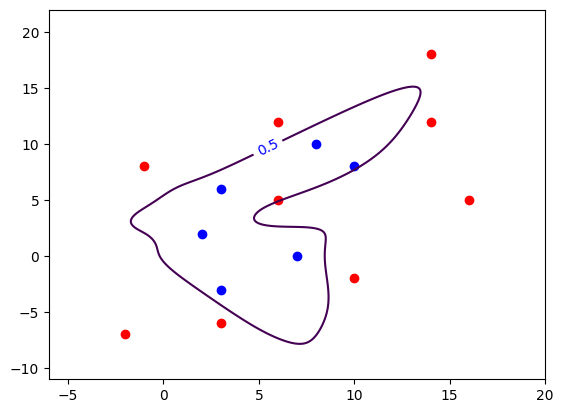

In [ ]:
# example 8
# x0, x1, x2
# 2x10x1
data = np.array([[-2,-7,1], [3,-3,0], [10,8,0], [16,5,1], [2,2,0], [-1,8,1], [8,10,0], [14,18,1], [7,0,0],[3,6,0],[6,12,1],[10,-2,1],[3,-6,1],[14,12,1],[6,5,1]])
nn = NeuralNetwork()
nn.add_layer(2)
nn.add_layer(10)
nn.add_layer(1)
nn.set_random_seed(32)
nn.fit(data)
x_pred = np.array([[10, 2], [1, 12]])
nn.predict(x_pred)
nn.display_contour()